In [11]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import copy

In [193]:
class WindyGridworld():
    
    def __init__(self, allow_stationary = False, stochastic=False):
        self.height = 7
        self.width = 10
        self.n = self.height * self.width
        
        self.permissible_actions = ["left", "right", "up", "down", "up-right", "up-left", "down-right", "down-left"]
        self.goal = np.array([7, 3])
        
        if allow_stationary:
            self.permissible_actions.append("stay")
            
        self.stochastic = stochastic
        
        self.wind_values = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])
        self.A = len(self.permissible_actions) 
    
    def get_permissible_actions(self, state):
        return self.permissible_actions
    
    def get_state_index(self, state):
        return ((self.height)*state[0]) + state[1]
    
    def get_action_index(self, action):
        return self.permissible_actions.index(action)
    
    def get_q_dim(self):
        return (self.n, self.A)
    
    def perform_action(self, state, action):
        # action is a string
        # state is a [x, y] array
        x = copy.deepcopy(state[0])
        y = copy.deepcopy(state[1])
        
        wind_up = self.wind_values[x]
        
        assert (x < self.width) and x > -1
        assert (y < self.height) and y > -1
        assert action in self.get_permissible_actions(state)
        
        if "left" in action:
            x = (x - 1) if x > 0 else x
        elif "right" in action:
            x = (x + 1) if x < self.width - 1 else x
        
        if "down" in action:
            y = (y - 1) if y > 0 else y
        elif "up" in action:
            y = (y + 1) if y < self.height - 1 else y
        
        if self.stochastic and wind_up > 0:
            wind_up += np.random.randint(-1, 2)
        
        y += wind_up
        y = (self.height - 1) if y > (self.height - 1) else y
        
        new_state = np.array([x, y])
        # print(f"Transitioned from {state} to {new_state} using {action}")
        goal_reached = np.all(new_state == self.goal)
        
        return new_state, -1, goal_reached
    
    def get_initial_state(self):
        return np.array([0, 3])
    
def eps_greedy_action(Q_row, eps):
    coin_toss = np.random.binomial(n=1, p=eps)
    if coin_toss:
        a = np.random.randint(0, len(Q_row))
    else:
        a = np.argmax(Q_row)
    return a
    
def sarsa(env, figname="plot.pdf", N_episodes=100, eps=0.1, alpha = 0.5, gamma=1):
    # initialise to all zeros to satisfy terminal conditional check
    n, a = env.get_q_dim()
    
    actions = env.get_permissible_actions(env.get_initial_state())
    Q_table = np.zeros(shape=(n, a))
    t_all = []
    t_ave = []
    
    
    for episode in range(N_episodes):
        terminate = False
        S = env.get_initial_state()
        S_indx = env.get_state_index(S)
        A_indx = eps_greedy_action(Q_table[S_indx, :], eps)
        A = actions[A_indx]
        t = 0
        
        while not terminate:
            S_new, R, terminate = env.perform_action(S, A)
            S_new_indx = env.get_state_index(S_new)
            A_prime_indx = eps_greedy_action(Q_table[S_new_indx, :], eps)
            Q_table[S_indx, A_indx] = Q_table[S_indx, A_indx] + alpha * (R + gamma*Q_table[S_new_indx, A_prime_indx] - Q_table[S_indx, A_indx])
            A = actions[A_prime_indx]
            A_indx = A_prime_indx
            S = copy.deepcopy(S_new)
            S_indx = env.get_state_index(S)
            t+=1
        
        t_all.append(t)
        t_ave.append(np.mean(t_all))
        #print(f"Episode {episode+1} took {t} steps")
    
    plt.figure(figsize=(4, 3), dpi=300)
    plt.plot(t_ave)
    plt.ylim([8, 50])
    plt.xlabel("Episode")
    plt.ylabel("Average Episode Length")
    plt.title(f"Average Episode Length {t_ave[-1]}")
    plt.savefig(figname)
    
    return Q_table, t_all

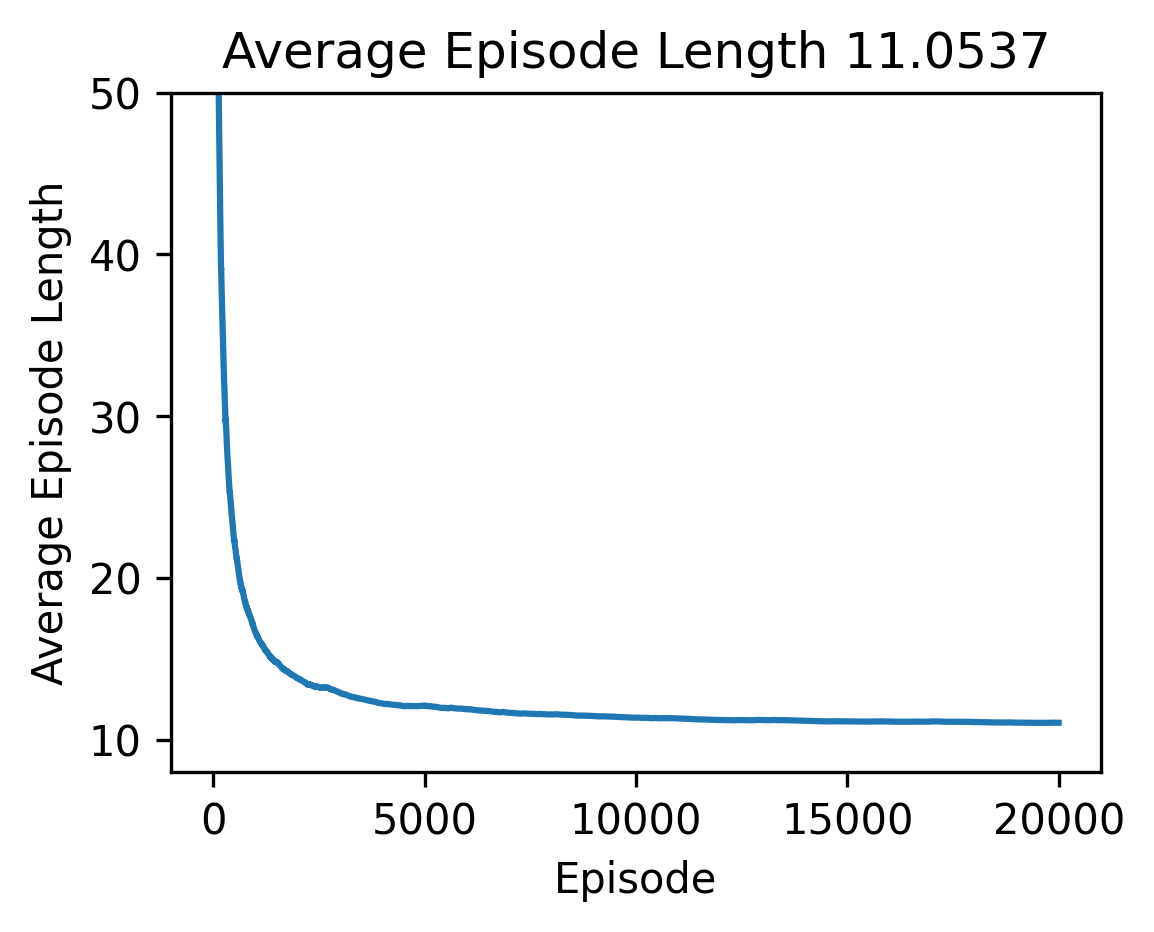

In [183]:
env = WindyGridworld()
Q_table, t_all = sarsa(env, "kings.pdf", 20000)

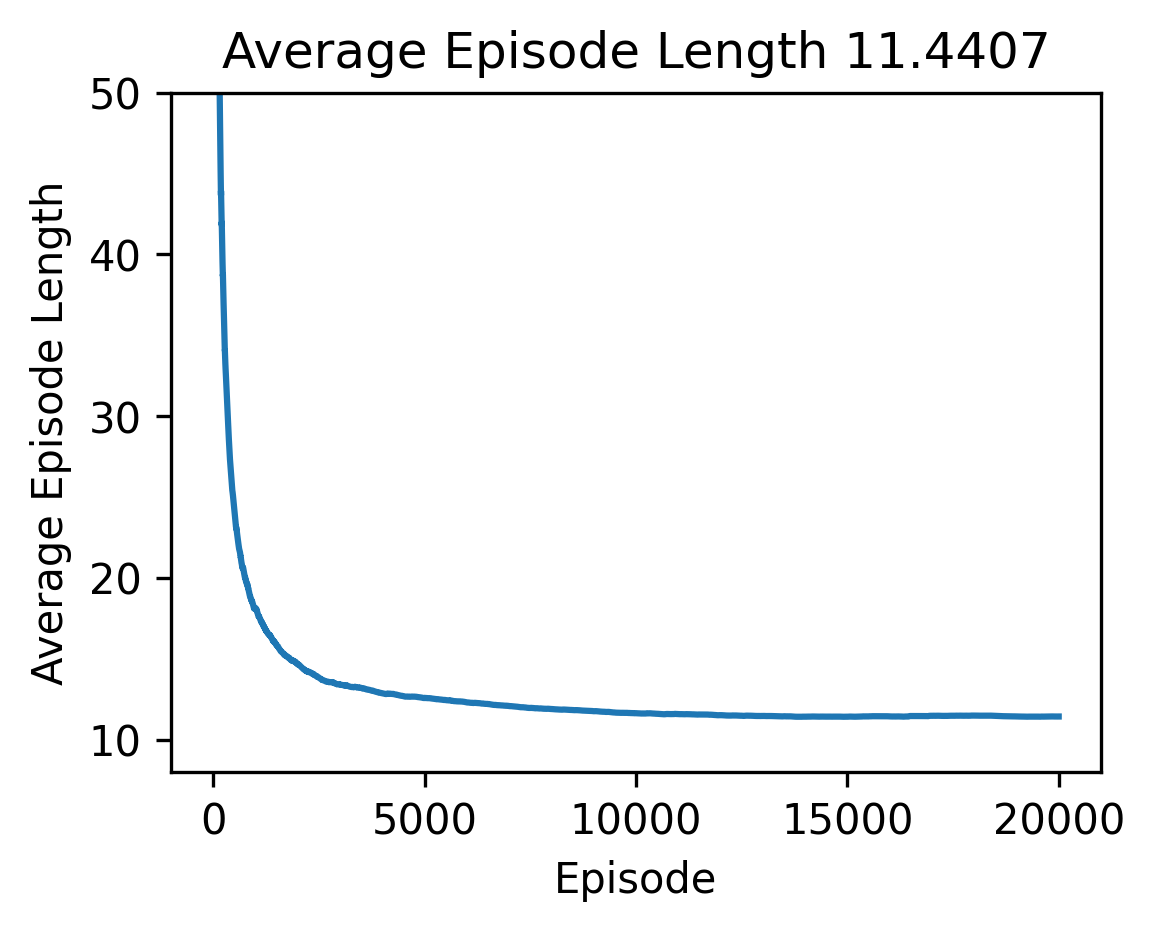

In [184]:
# allow staying still:
env = WindyGridworld(allow_stationary = True)
Q_table, t_all = sarsa(env, "kings_stationary.pdf", 20000)

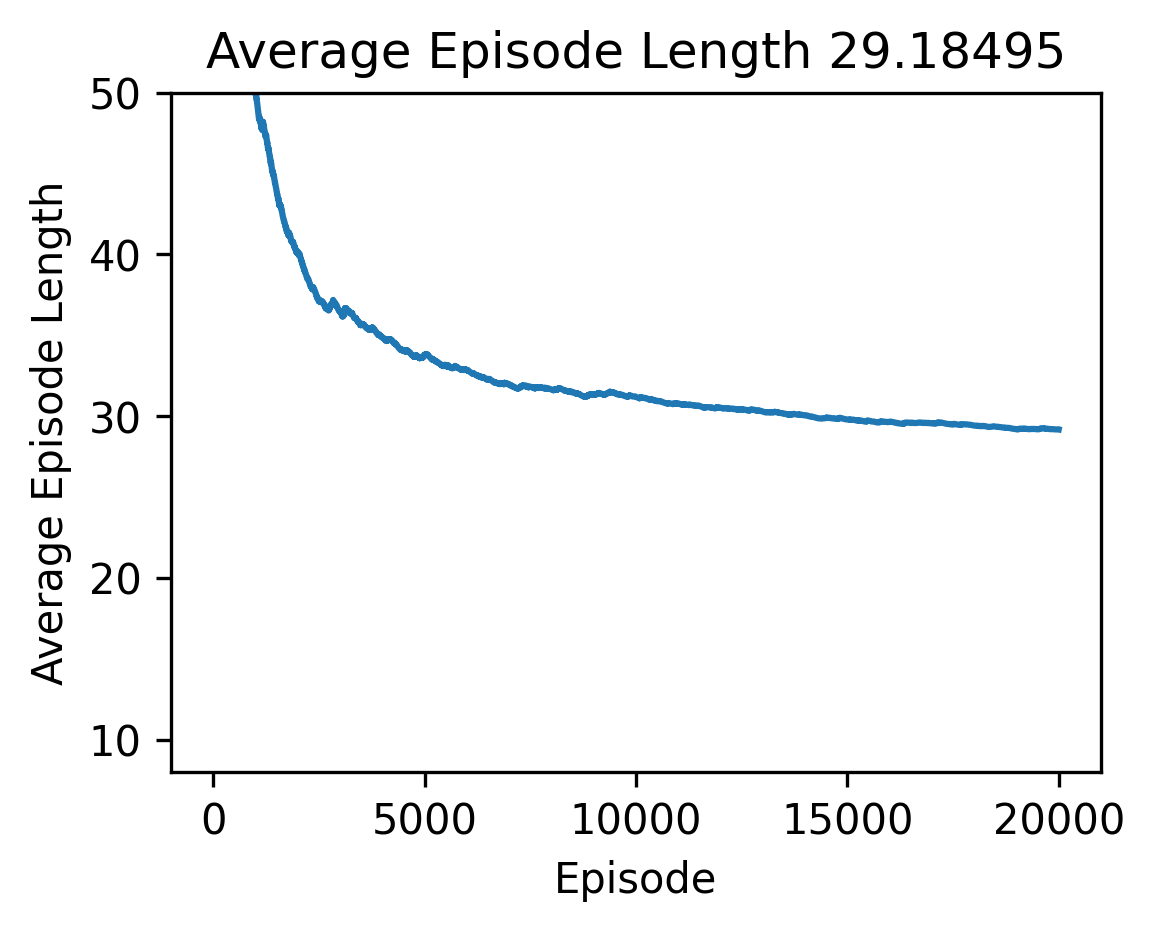

In [194]:
env = WindyGridworld(stochastic=True)
Q_table, t_all = sarsa(env, "kings_stochastic.pdf", 20000)